In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
from tidy3d import web

In [2]:
# Wavelength and frequency range
freq_range = (200e12, 400e12)
lambda_range = (td.constants.C_0/freq_range[1], td.constants.C_0/freq_range[0])
freq0 = np.sum(freq_range)/2
Nfreq = 301

# frequencies and wavelengths of monitor
monitor_freqs = np.linspace(freq_range[0], freq_range[1], Nfreq)
monitor_lambdas = td.constants.C_0 / monitor_freqs

# central frequency, frequency pulse width and total running time
lambda0 = td.C_0 / freq0
bandwidth = 0.18  # bandwidth of source in units of delta frequency.  0.38 for broadband

freqw  = bandwidth * (freq_range[1] - freq_range[0])
t_stop = 100 / freq0

# Thickness and refractive index of slab
t_slab = 0.5
n_slab = 3.5
mat_slab = td.Medium(permittivity=n_slab**2, name='silicon')

# Grid resolution (cells per um)
# dl = lambda_range[0] / 30 / n_slab
dl = 6e-3

# space between slabs and sources and PML
spacing = 1 * lambda_range[-1]

# simulation size
sim_size = Lx, Ly, Lz = (2.0, 2.0, 2*spacing + t_slab)

In [3]:
def slab_analytical(d, n, wvl):
    """ computes transmision as a function of slab thickness (d), refractive index (n), and wavelength (wvl). """
    rho = (n-1)/(n+1)
    t = ((1+rho)*(1-rho)*np.exp(-2j*np.pi*n*d/wvl)) / (1 - rho**2*np.exp(-4j*np.pi*n*d/wvl))
    return np.abs(t)**2

transmission_analytical = slab_analytical(t_slab, n_slab, monitor_lambdas)

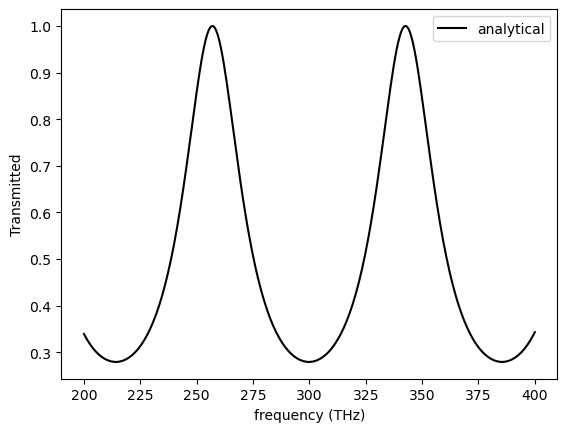

In [4]:
plt.figure()
plt.plot(monitor_freqs / 1e12, transmission_analytical, 'k', label='analytical')
plt.xlabel('frequency (THz)')
plt.ylabel('Transmitted')
plt.legend()
plt.show()

In [5]:
slab = td.Structure(
    geometry=td.Box(
        center=(0, 0, -Lz/2 + spacing + t_slab/2),
        size=(td.inf, td.inf, t_slab),
    ),
    medium=mat_slab,
    name='slab',
)

In [14]:
# Here we define the planewave source, placed just in advance (towards negative z) of the slab
source = td.PlaneWave(
    source_time = td.GaussianPulse(
        freq0=freq0,
        fwidth=freqw
    ),
    size=(td.inf, td.inf, 0),
    center=(0, 0, -Lz/2+spacing/2),
    direction='+',
    pol_angle=0,
    name='planewave',
)

In [15]:
# We are interested in measuring the transmitted flux, so we set it to be an oversized plane.
monitor = td.FluxMonitor(
    center = (0, 0, Lz/2 - spacing/2),
    size = (td.inf, td.inf, 0),
    freqs = monitor_freqs,
    name='flux',
)

In [35]:
# I put an extra reflection monitor for analysis
monitor2 = td.FluxMonitor(
    center = (0, 0, -Lz/2),
    size = (td.inf, td.inf, 0),
    freqs = monitor_freqs,
    name='reflection',
)

In [36]:
sim = td.Simulation(
    center = (0, 0, 0),
    size = sim_size,
    grid_spec = td.GridSpec.uniform(dl=dl),
    structures = [slab],
    sources = [source],
    monitors = [monitor, monitor2],
    run_time = t_stop,
    boundary_spec = td.BoundarySpec.pml(z=True),
    normalize_index = None,
)

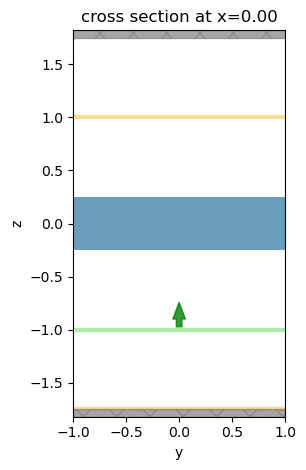

In [37]:
sim.plot(x=0)
plt.show()

In [24]:
print(sim_size, -Lz/2 - spacing/2, spacing/2)

(2.0, 2.0, 3.49792458) -2.498443435 0.749481145


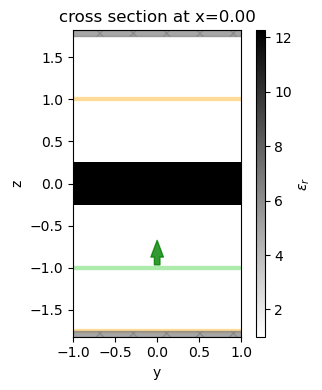

In [38]:
# plot the permittivity 
freqs_plot = (freq_range[0], freq_range[1])
fig, ax = plt.subplots(1, tight_layout=True, figsize=(8, 4))
sim.plot_eps(x=0, freq=None, ax=ax)
plt.show()

In [39]:
times = np.arange(0, sim.run_time, sim.dt)
amps = np.real(sim.sources[0].source_time.amp_time(times))

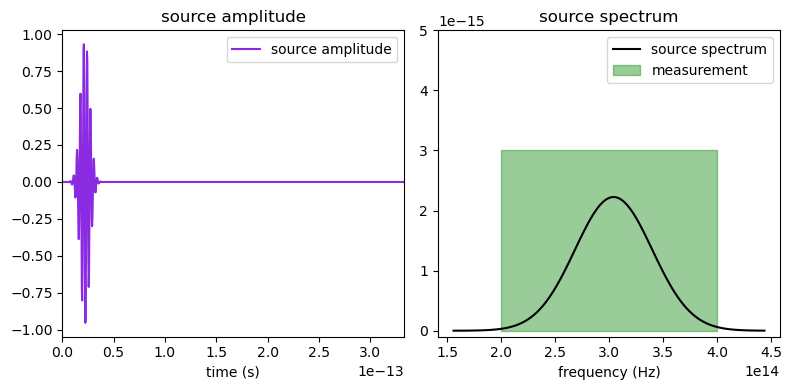

In [40]:
# Check probe and source
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
ax1 = sim.sources[0].source_time.plot(times=np.linspace(0, sim.run_time, 1001), ax=ax1)
ax1.set_xlim(0, sim.run_time)
ax1.legend(('source amplitude',))
ax2 = sim.sources[0].source_time.plot_spectrum(times=np.linspace(0, sim.run_time, 1001), val='abs', ax=ax2)
fill_max = 30e-16 # 10e-16
ymax = 50e-16 # 20e-16
ax2.fill_between(freq_range, [-0e-16, -0e-16], [fill_max, fill_max], alpha=0.4, color='g')
ax2.legend(('source spectrum', 'measurement'))
ax2.set_ylim(-1e-16, ymax)
plt.show()

In [41]:
sim0 = sim.copy(update={'structures':[]})

In [42]:
sim_data0 = web.run(sim0, task_name='lecture02_slab_narrowband_normalization', path=f'data/data0_narrowband.hdf5', verbose=True)
sim_data = web.run(sim, task_name='lecture02_slab_narrowband_transmission', path=f'data/data_narrowband.hdf5', verbose=True)

[16:49:36] Created task 'lecture02_slab_narrowband_normalization' with task_id                        ]8;id=179831;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=93949;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#189\189]8;;\
           'fdve-eef8355d-0bf8-464d-9498-f9a825995fffv1'.                                                          

           View task using web UI at                                                                  ]8;id=147521;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=230761;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#191\191]8;;\
           ]8;id=19566;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eef8355d-0bf8-464d-9498-f9a825995fffv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=329456;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eef8355d-0bf8-464d-9498-f9a825995fffv1\taskId]8;;\]8;id=19566;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eef8355d-0bf8-464d-9498-f9a825995fffv1\=]8;;\]8;id=589702;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eef8355d-0bf8-464d-9498-f9a825995fffv1\fdve]8;;\]8;id=19566;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eef8355d-0bf8-464d-9498-f9a825995fffv1\-eef8355d-0bf8-464d-9498-f9a825995ff]8;;\              
           ]8;id=19566;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eef8355d-0bf8-464d-9498-f9a825995fffv1\fv1']8;;\.                                                                                                   

Output()

[16:49:39] status = queued                                                                            ]8;id=881664;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=17057;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#363\363]8;;\

Output()

[16:49:42] status = preprocess                                                                        ]8;id=180295;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=274208;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#357\357]8;;\

[16:49:46] Maximum FlexCredit cost: 0.615. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=917937;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=51001;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#343\343]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=914749;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=953455;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#379\379]8;;\

[16:49:47] running solver                                                                             ]8;id=789633;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=313369;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#389\389]8;;\

           To cancel the simulation, use 'web.delete(task_id)' or delete the task in the web UI.      ]8;id=59925;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=558043;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#390\390]8;;\
           Terminating the Python script will not stop the job running on the cloud.                               

Output()

[16:50:00] early shutoff detected, exiting.                                                           ]8;id=874297;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=417255;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#407\407]8;;\

           status = postprocess                                                                       ]8;id=565527;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=6088;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#424\424]8;;\

Output()

[16:50:03] status = success                                                                           ]8;id=843498;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=653308;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#431\431]8;;\

Output()

[16:50:05] loading SimulationData from data/data0_narrowband.hdf5                                     ]8;id=833392;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=584337;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#609\609]8;;\

[16:50:05] Created task 'lecture02_slab_narrowband_transmission' with task_id                         ]8;id=103738;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=540559;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#189\189]8;;\
           'fdve-6aa44d05-c242-41d4-93ee-07792d982a56v1'.                                                          

           View task using web UI at                                                                  ]8;id=690336;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=879463;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#191\191]8;;\
           ]8;id=940398;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6aa44d05-c242-41d4-93ee-07792d982a56v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=66535;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6aa44d05-c242-41d4-93ee-07792d982a56v1\taskId]8;;\]8;id=940398;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6aa44d05-c242-41d4-93ee-07792d982a56v1\=]8;;\]8;id=749100;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6aa44d05-c242-41d4-93ee-07792d982a56v1\fdve]8;;\]8;id=940398;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6aa44d05-c242-41d4-93ee-07792d982a56v1\-6aa44d05-c242-41d4-93ee-07792d982a5]8;;\              
           ]8;id=940398;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6aa44d05-c242-41d4-93ee-07792d982a56v1\6v1']8;;\.                                                                                                   

Output()

[16:50:09] status = queued                                                                            ]8;id=596582;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=445544;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#363\363]8;;\

Output()

[16:50:11] status = preprocess                                                                        ]8;id=356440;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=567790;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#357\357]8;;\

[16:50:16] Maximum FlexCredit cost: 0.615. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=423535;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=93883;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#343\343]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=539682;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=918481;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#379\379]8;;\

           running solver                                                                             ]8;id=158594;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=691952;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#389\389]8;;\

           To cancel the simulation, use 'web.delete(task_id)' or delete the task in the web UI.      ]8;id=100775;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=941043;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#390\390]8;;\
           Terminating the Python script will not stop the job running on the cloud.                               

Output()

[16:50:33] early shutoff detected, exiting.                                                           ]8;id=904147;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=340857;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#407\407]8;;\

[16:50:34] status = postprocess                                                                       ]8;id=423172;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=324992;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#424\424]8;;\

Output()

[16:50:36] status = success                                                                           ]8;id=202266;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=441269;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#431\431]8;;\

Output()

[16:50:39] loading SimulationData from data/data_narrowband.hdf5                                      ]8;id=407235;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=799120;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#609\609]8;;\

In [ ]:
# sim_data = td.SimulationData.dict_from_hdf5('data/data_narrowband.hdf5')
# sim_data0 = td.SimulationData.dict_from_hdf5('data/data0_narrowband.hdf5')
# sim_data = web.load('fdve-6e10b29f-5387-41f8-8755-b6543a4710cbv1')
# sim_data0 = web.load('fdve-9cb359d1-cae7-45a7-8c78-6a27fd9d2227v1')

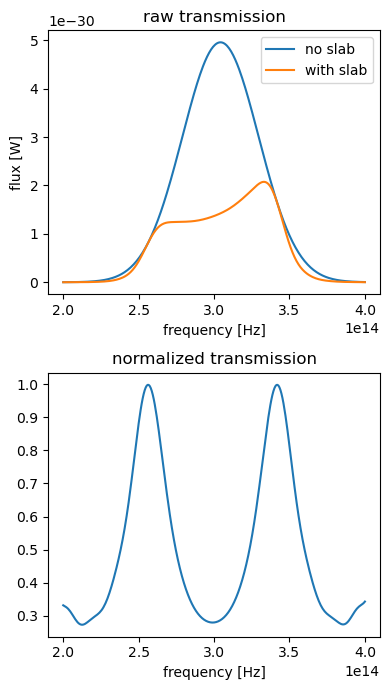

In [43]:
# Retrieve the power flux through the monitor plane.
transmission0 = sim_data0['flux'].flux
transmission = sim_data['flux'].flux
reflection0 = sim_data0['reflection'].flux
reflection = sim_data['reflection'].flux
transmission_normalized = transmission / transmission0

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 7), tight_layout=True)
transmission0.plot(ax=ax1, label='no slab')
transmission.plot(ax=ax1, label='with slab')
transmission_normalized.plot(ax=ax2)
ax1.legend()
ax1.set_title('raw transmission')
ax2.set_title('normalized transmission')
plt.show()

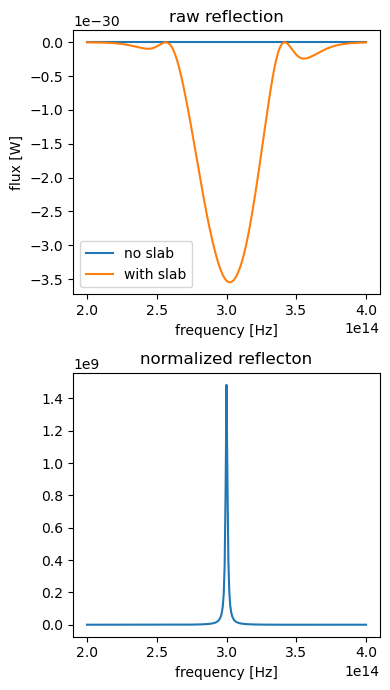

In [44]:
# Retrieve the power flux through the reflection monitor plane.
reflection_normalized = reflection / reflection0

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 7), tight_layout=True)
reflection0.plot(ax=ax1, label='no slab')
reflection.plot(ax=ax1, label='with slab')
reflection_normalized.plot(ax=ax2)
ax1.legend()
ax1.set_title('raw reflection')
ax2.set_title('normalized reflection')
plt.show()

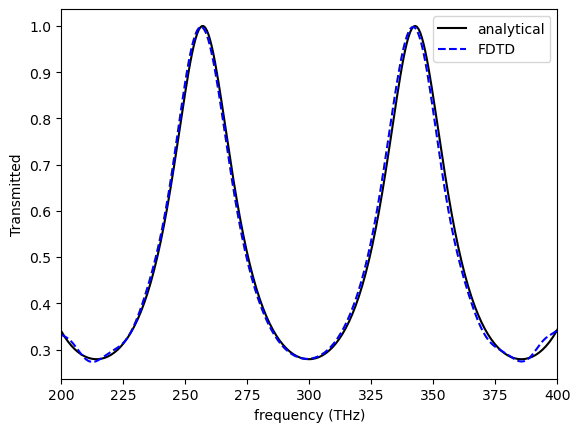

In [45]:
plt.figure()
plt.plot(monitor_freqs/1e12, transmission_analytical, 'k', label='analytical')
plt.plot(monitor_freqs/1e12, transmission_normalized, 'b--', label='FDTD')
plt.xlabel('frequency (THz)')
plt.xlim([200, 400])
plt.ylabel('Transmitted')
plt.legend()
plt.show()

In [46]:
bandwidth = 0.38

freqw  = bandwidth * (freq_range[1] - freq_range[0])

# make a copy of the original simulation, but change the frequency width of the source
bw_source = source.copy(update={
    'source_time':source.source_time.copy(update={'fwidth':freqw})
    }
)
sim_bw = sim.copy(update={'sources':[bw_source]})

# make the normalization simulation for this
sim_bw0 = sim_bw.copy(update={'structures':[]})

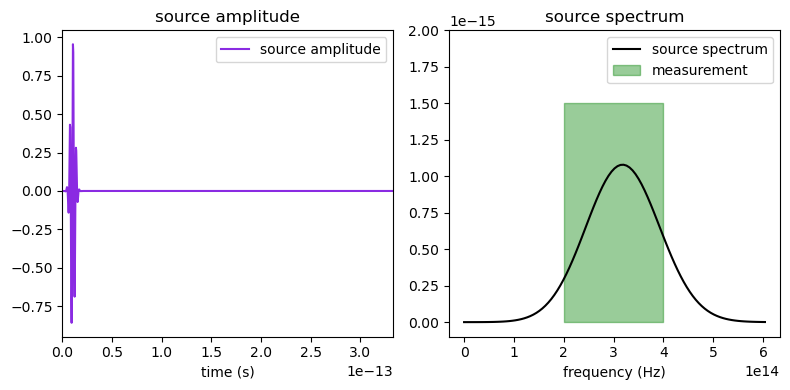

In [47]:
# Check probe and source, looks now like the source spectrum fully covers the green square
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
ax1 = sim_bw.sources[0].source_time.plot(times=np.linspace(0, sim_bw.run_time, 1001), ax=ax1)
ax1.set_xlim(0, sim_bw.run_time)
ax1.legend(('source amplitude',))
ax2 = sim_bw.sources[0].source_time.plot_spectrum(times=np.linspace(0, sim_bw.run_time, 1001), val='abs', ax=ax2)
fill_max = 15e-16
ymax = 20e-16
ax2.fill_between(freq_range, [-0e-16, -0e-16], [fill_max, fill_max], alpha=0.4, color='g')
ax2.legend(('source spectrum', 'measurement'))
ax2.set_ylim(-1e-16, ymax)
plt.show()

In [ ]:
sim_bw_data0 = web.run(sim_bw0, task_name='lecture02_slab_broadband_normalizatio', path=f'data/data0_broadband.hdf5')
sim_bw_data = web.run(sim_bw, task_name='lecture02_slab_broadband_transmission', path=f'data/data_broadband.hdf5')

In [ ]:
# Retrieve the power flux through the monitor plane.
transmission0 = sim_bw_data0['flux'].flux
transmission = sim_bw_data['flux'].flux
transmission_normalized = transmission / transmission0

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 7), tight_layout=True)
transmission0.plot(ax=ax1, label='no slab')
transmission.plot(ax=ax1, label='with slab')
transmission_normalized.plot(ax=ax2)
ax1.legend()
ax1.set_title('raw transmission')
ax2.set_title('normalized transmission')
plt.show()

In [ ]:
plt.figure()
plt.plot(monitor_freqs/1e12, transmission_analytical, 'k', label='analytical')
plt.plot(monitor_freqs/1e12, transmission_normalized, 'b--', label='FDTD')
plt.xlabel('frequency (THz)')
plt.xlim([200, 400])
plt.ylabel('Transmitted')
plt.legend()
plt.show()